In [33]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import shutil
from tqdm import tqdm
from PIL import Image
os.getcwd()
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.2.0


In [34]:
#Ref: https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.optimizers import SGD
import pandas as pd
import numpy as np
import keras 
from keras.layers import *
from keras.models import *

traindf=pd.read_csv('train.csv',dtype=str)
testdf=pd.read_csv('test.csv',dtype=str)

traindf['age']=traindf.age.astype('int64')

testdf['age']=traindf.age.astype('int64')

print(traindf.head())
print(testdf.head())

print(traindf.info())
print(testdf.info())


                                           full_path gender  age
0  data/imdb/50/nm0004950_rm4036071168_1972-4-17_...      0   38
1  data/imdb/77/nm0004977_rm474265344_1973-7-15_2...      1   37
2  data/imdb/21/nm0019221_rm3640760320_1948-9-11_...      1   16
3  data/imdb/34/nm1289434_rm2872508160_1983-2-23_...      0   32
4  data/imdb/90/nm0001590_rm687003392_1952-5-15_2...      1   57
                                           full_path gender  age
0  data/imdb/44/nm0089244_rm238668800_1939-8-7_19...      0   38
1          data/wiki/21/32518421_1991-09-01_2015.jpg      1   37
2          data/wiki/76/38687576_1939-08-29_1961.jpg      1   16
3  data/imdb/88/nm0005388_rm594123264_1970-5-15_2...      1   32
4  data/imdb/25/nm0001325_rm2254805248_1959-11-3_...      1   57
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156918 entries, 0 to 156917
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   full_path  156918 non-nul

In [35]:
test_labels = testdf['age']
print(test_labels)

0        38
1        37
2        16
3        32
4        57
         ..
52561    20
52562    49
52563    24
52564    29
52565    41
Name: age, Length: 52566, dtype: int64


In [65]:
#train and validation data generators

img_dim=128


datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)
#        rotation_range=90,
#        shear_range=0.2,
#        horizontal_flip=True,
#        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['age'],
subset="training",
#try a smaller batch size                                            
batch_size=32,
seed=42,
shuffle=True,
class_mode='raw', 
target_size=(img_dim,img_dim))

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['age'],
subset="validation",
batch_size=32, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=True,
class_mode='raw',
target_size=(img_dim,img_dim))

Found 125535 validated image filenames.
Found 31383 validated image filenames.


In [66]:
#test data generator

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=None,
x_col='full_path',
y_col=None,
batch_size=1, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_dim,img_dim))




Found 52566 validated image filenames.


In [67]:
#Define model

inputs = Input(shape = (img_dim,img_dim, 3))

# Begin
model = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides= 2, activation='relu', input_shape=(img_dim, img_dim, 3))(inputs)
model = MaxPool2D(pool_size=(3, 3), strides= 2)(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(model)
model=Flatten()(model)

age_model = Dense(256, activation='relu')(model)
age_model = Dropout(0.4)(age_model)
age_model = Dense(512, activation='relu')(age_model)
age_model = Dropout(0.4)(age_model)
age_model= Dense(1, activation='linear',name='age')(age_model)


In [68]:
model = Model(inputs=inputs, outputs=age_model)
model.compile(optimizer = tf.keras.optimizers.Adam(0.01), loss ='mse',metrics=['mae'])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 31, 31, 128)       7385

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True)]

BATCH_SIZE=128

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

#for one output:
history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                    epochs=10,callbacks=callbacks)



Epoch 1/10
3922/3922 [==============================] - 2440s 622ms/step - loss: 19966.4393 - mae: 15.6630 - val_loss: 308.4889 - val_mae: 14.4939
Epoch 2/10
3922/3922 [==============================] - 2355s 600ms/step - loss: 224.7364 - mae: 11.5204 - val_loss: 216.5033 - val_mae: 11.0077
Epoch 3/10
1421/3922 [=========>....................] - ETA: 24:19 - loss: 201.3916 - mae: 11.0512

In [ ]:
model.save('cnn_age_model.h5')
print(history.history.keys())

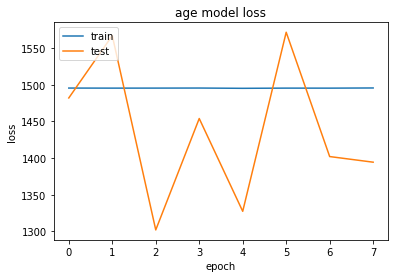

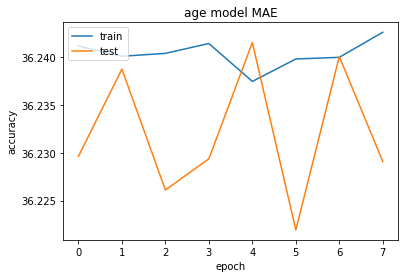

<Figure size 432x288 with 0 Axes>

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('age_only_MSE.png')
plt.clf()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('age model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('age_only_MAE.png')
plt.clf()

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mae,loss,mae,epoch
3,1454.03125,36.229370,1495.608193,36.241421,3
4,1327.46875,36.241524,1495.237532,36.237461,4
5,1571.71875,36.221939,1495.501733,36.239803,5
6,1402.15625,36.240055,1495.469240,36.239979,6
7,1394.46875,36.229084,1495.713226,36.242599,7


In [47]:
#Evaluate
loss, mae = model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 36.23


In [48]:
#Make predictions

test_generator.reset() #reset the test_generator before whenever you call the predict_generator
age_predictions=model.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST,verbose=1)

 2410/52566 [>.............................] - ETA: 8:06

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


11226/52566 [=====>........................] - ETA: 6:34

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16036032132 bytes but only got 0. Skipping tag 50687
  " Skipping tag %s" % (size, len(data), tag)


34095/52566 [==================>...........] - ETA: 2:55

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


52566/52566 [==============================] - 497s 9ms/step


In [52]:
test_predictions = age_predictions.flatten()
#.astype(int)
print(test_predictions)

[0. 0. 0. ... 0. 0. 0.]


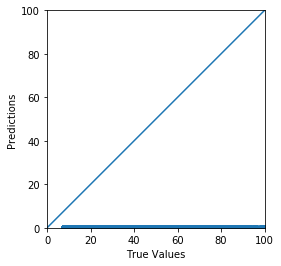

In [50]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

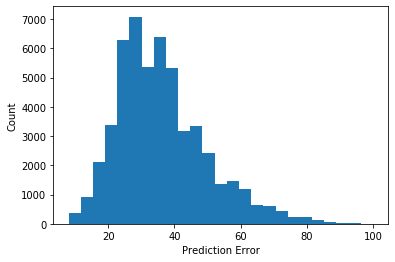

In [54]:
error = np.abs(test_predictions - test_labels)
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")